In [ ]:
# check GPU
!nvidia-smi

Thu Nov 28 20:37:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
!git clone https://github.com/FaresMallouli/ZEN
repo_name='ZEN'
os.chdir(f'{repo_name}')

Cloning into 'dressing-in-order'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 213 (delta 87), reused 195 (delta 82), pack-reused 0 (from 0)
Receiving objects: 100% (213/213), 5.14 MiB | 10.89 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
!pip install scikit-image==0.18.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 39.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.3 MB/s eta 0:00:00
  Created wheel for scikit-image: filename=scikit_image-0.18.2-cp310-cp310-linux_x86_64.whl size=36001575 sha256=0b915282d089cdaffb29bf6dff868171285be1d0de41439baa18033a9e9148a7
  Stored in directory: /root/.cache/pip/wheels/73/53/00/eda30fe5a356178fa5213b63cfad068bf6d656f3aee86be531
Successfully built scikit-image
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [ ]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00


# Step 1: Download Data


In [ ]:
# download data from https://github.com/yumingj/DeepFashion-MultiModal
import os
from tqdm.notebook import tqdm

if not os.path.exists("data/"):
  os.system("mkdir data")

def download_from_gdrive(dst_root, fn, gdrive_path, iszip=True):
  if not os.path.exists(dst_root):
    os.system("mkdir {}".format(dst_root))
  if not os.path.exists("{}/{}".format(dst_root, fn)):
    os.system("gdown {}".format(gdrive_path))
    if iszip:
      os.system("unzip {}.zip".format(fn))
      os.system("rm {}.zip".format(fn))
    os.system("mv {} {}/".format(fn, dst_root))
  print("download {}.".format(fn))

# download data
download_from_gdrive("data", "testM_lip", "1toeQwAe57LNPTy9EWGG0u1XfTI7qv6b1")
download_from_gdrive("data", "images", "1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN")
download_from_gdrive("data","fasion-pairs-test.csv","12fZKGf0kIu5OX3mjC-C3tptxrD8sxm7x",iszip=False)
download_from_gdrive("data","fasion-annotation-test.csv","1MxkVFFtNsWFshQp_TA7qwIGEUEUIpYdS",iszip=False)
download_from_gdrive("data","standard_test_anns.txt","19nJSHrQuoJZ-6cSl3WEYlhQv6ZsAYG-X",iszip=False)

# filter images (exclude training data and rename the files)
if not os.path.exists("data/test"):
  os.mkdir("data/test")
target_fns = [fn[:-4] for fn in os.listdir("data/testM_lip")]
for fn in tqdm(os.listdir("data/images")):
  elements = fn.split("-")
  elements[2] = elements[2].replace("_","")
  last_elements = elements[-1].split("_")
  elements[-1] = last_elements[0] + "_" + last_elements[1] + last_elements[2]
  new_fn = "fashion"+"".join(elements)

  if new_fn[:-4] in target_fns:
    os.system("mv {} {}".format("data/images/"+fn, "data/test/"+new_fn))



download testM_lip.
download images.
download fasion-pairs-test.csv.
download fasion-annotation-test.csv.
download standard_test_anns.txt.


  0%|          | 0/44096 [00:00<?, ?it/s]

# Step 2: Load Pre-trained Model

In [ ]:
import torch
from models.dior_model import DIORModel
import os, json
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataroot = 'data'
exp_name = 'DIORv1_64' # DIOR_64
epoch = 'latest'
netG = 'diorv1' # dior
ngf = 64

## this is a dummy "argparse"
class Opt:
    def __init__(self):
        pass
if True:
    opt = Opt()
    opt.dataroot = dataroot
    opt.isTrain = False
    opt.phase = 'test'
    opt.n_human_parts = 8; opt.n_kpts = 18; opt.style_nc = 64
    opt.n_style_blocks = 4; opt.netG = netG; opt.netE = 'adgan'
    opt.ngf = ngf
    opt.norm_type = 'instance'; opt.relu_type = 'leakyrelu'
    opt.init_type = 'orthogonal'; opt.init_gain = 0.02; opt.gpu_ids = [0]
    opt.frozen_flownet = True; opt.random_rate = 1; opt.perturb = False; opt.warmup=False
    opt.name = exp_name
    opt.vgg_path = ''; opt.flownet_path = ''
    opt.checkpoints_dir = 'checkpoints'
    opt.frozen_enc = True
    opt.load_iter = 0
    opt.epoch = epoch
    opt.verbose = False

# create model
#os.mkdir("checkpoints")
download_from_gdrive("checkpoints", "DIORv1_64", "1MyHq-P0c8zz7ey7p_HTTZKeMie5ZuNlb")

model = DIORModel(opt)
model.setup(opt)


download DIORv1_64.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 92.2MB/s]


load vgg ckpt from torchvision dict.
[init] init pre-trained model vgg.
initialize network with orthogonal
initialize network with orthogonal
initialize network with kaiming
initialize network with orthogonal
[init] frozen net netVGG.
[init] frozen net netFlow.
[init] frozen net netE_attr.
[init] frozen net netE_attr.
loading the model from checkpoints/DIORv1_64/latest_net_E_attr.pth
loading the model from checkpoints/DIORv1_64/latest_net_G.pth
not exsits checkpoints/DIORv1_64/latest_net_VGG.pth
loading the model from checkpoints/DIORv1_64/latest_net_Flow.pth
---------- Networks initialized -------------
[Network E_attr] Total number of parameters : 1.191 M
[Network G] Total number of parameters : 16.501 M
[Network VGG] Total number of parameters : 0.113 M
[Network Flow] Total number of parameters : 6.608 M
-----------------------------------------------
[tensorboard] init tensorboard @ checkpoints/DIORv1_64/test


/content/dressing-in-order/models/base_model.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=str(self.device))


-1

In [ ]:
# load data
from datasets.deepfashion_datasets import DFVisualDataset
Dataset = DFVisualDataset
ds = Dataset(dataroot=dataroot, dim=(256,176), n_human_part=8)

# preload a set of pre-selected models defined in "standard_test_anns.txt" for quick visualizations
inputs = dict()
for attr in ds.attr_keys:
    inputs[attr] = ds.get_attr_visual_input(attr)

# define some tool functions for I/O
def load_img(pid, ds):
    if len(pid[0]) < 10: # load pre-selected models
        person = inputs[pid[0]]
        person = (i.cuda() for i in person)
        pimg, parse, to_pose = person
        pimg, parse, to_pose = pimg[pid[1]], parse[pid[1]], to_pose[pid[1]]
    else: # load model from scratch
        person = ds.get_inputs_by_key(pid[0])
        person = (i.cuda() for i in person)
        pimg, parse, to_pose = person
    return pimg.squeeze(), parse.squeeze(), to_pose.squeeze()

def plot_img(pimg=[], gimgs=[], oimgs=[], gen_img=[], pose=None):
    if pose != None:
        import utils.pose_utils as pose_utils
        print(pose.size())
        kpt = pose_utils.draw_pose_from_map(pose.cpu().numpy().transpose(1,2,0),radius=6)
        kpt = kpt[0]
    if not isinstance(pimg, list):
        pimg = [pimg]
    if not isinstance(gen_img, list):
        gen_img = [gen_img]
    out = pimg + gimgs + oimgs + gen_img
    if out:
        out = torch.cat(out, 2).float().cpu().detach().numpy()
        out = (out + 1) / 2 # denormalize
        out = np.transpose(out, [1,2,0])

        if pose != None:
            out = np.concatenate((kpt, out),1)
    else:
        out = kpt
    fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
    plt.axis('off')
    plt.imshow(out)

# define dressing-in-order function (the pipeline)
def dress_in_order(model, pid, pose_id=None, gids=[], ogids=[], order=[5,1,3,2], perturb=False):
    PID = [0,4,6,7]
    GID = [2,5,1,3]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    if perturb:
        pimg = perturb_images(pimg[None])[0]
    if not pose_id:
        to_pose = from_pose
    else:
        to_img, _, to_pose = load_img(pose_id, ds)
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])


    # swap base garment if any
    gimgs = []
    for gid in gids:
        _,_,k = gid
        gimg, gparse, pose =  load_img(gid, ds)
        seg = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=gid[2])
        gsegs[gid[2]] = seg
        gimgs += [gimg * (gparse == gid[2])]

    # encode garment (overlay)
    garments = []
    over_gsegs = []
    oimgs = []
    for gid in ogids:
        oimg, oparse, pose = load_img(gid, ds)
        oimgs += [oimg * (oparse == gid[2])]
        seg = model.encode_single_attr(oimg[None], oparse[None], pose[None], to_pose[None], i=gid[2])
        over_gsegs += [seg]

    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    return pimg, gimgs, oimgs, gen_img[0], to_pose





- 'top':5, # dress is also considered as top.
- 'bottom':1,
- 'hair':2,
- 'jacket':3


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Virtual Try-On

Users can control the tuck-in and tuck-out results when there is overlap between the top garment and the bottom garment.

torch.Size([18, 256, 176])


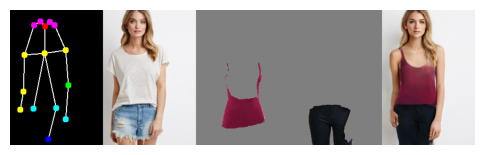

In [ ]:
# person id
pid = ("fashionWOMENTees_Tanksid0000789802_1front.jpg", None , None) # load person from the file

# garments to try on (ordered)
gids = [
    ("fashionWOMENTees_Tanksid0000334328_1front.jpg",None,5),
    ("fashionWOMENTees_Tanksid0000699110_1front.jpg",None,1),
       ]



# dressing in order
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid=pid, gids=gids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)